In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [33]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *
figsize = (7,1.65)
fontsize = 11

In [47]:
dataf = "../../data/clwbvsntstore.csv"

In [48]:
!sha256sum $dataf

df1cbcf11032e8be0bb365680b7db8ccbf6425adc30b8453fac5cbdd12cbfc89  ../../data/clwbvsntstore.csv


In [49]:
!head $dataf

64, 1, 172.501, 162.096, 563.459
64, 2, 128.086, 116.502, 388.013
64, 4, 110.07, 102.141, 296.658
64, 8, 101.261, 93.475, 250.362
64, 16, 95.0707, 88.8732, 228.521
64, 32, 92.5362, 86.0857, 217.861
64, 64, 91.027, 85.3313, 211.593
128, 1, 182.989, 179.248, 691.831
128, 2, 146.814, 138.451, 512.116
128, 4, 135.984, 128.918, 425.625


In [50]:
flights = sns.load_dataset("flights")
flights.T

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
year,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949,...,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960
month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
passengers,112,118,132,129,121,135,148,148,136,119,...,419,461,472,535,622,606,508,461,390,432


In [65]:
df = pd.read_csv(dataf, index_col=None, names=['Write size', 'Drain interval', 'CLWB+SFENCE', 'CLFLUSHOPT', 'NT-Store'])
df

,Write size,Drain interval,CLWB+SFENCE,CLFLUSHOPT,NT-Store
0,64,1,172.5010,162.0960,563.459
1,64,2,128.0860,116.5020,388.013
2,64,4,110.0700,102.1410,296.658
3,64,8,101.2610,93.4750,250.362
4,64,16,95.0707,88.8732,228.521
...,...,...,...,...,...
58,16384,4,2209.0100,2206.5200,33783.800
59,16384,8,2077.3900,2066.2000,33737.800
60,16384,16,2018.3600,2007.8600,33721.000
61,16384,32,1976.9400,1968.0100,33678.200


In [76]:
perf_df = df[df['Drain interval'] == 4][['CLWB+SFENCE', 'CLFLUSHOPT']]
perf_df.index = df[df['Drain interval'] == 4]['Write size']
perf_df

,CLWB+SFENCE,CLFLUSHOPT
Write size,,
64,110.070,102.141
128,135.984,128.918
256,156.956,150.305
512,257.085,243.042
1024,341.024,318.579
2048,412.902,404.243
4096,673.315,664.105
8192,1207.110,1200.430
16384,2209.010,2206.520


<AxesSubplot:>

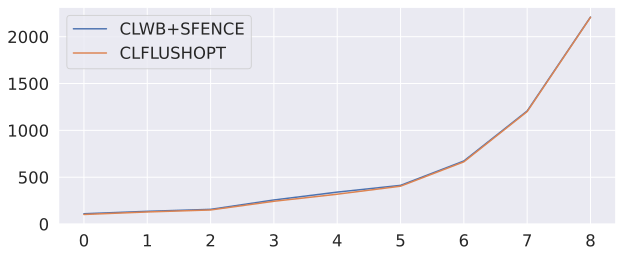

In [75]:
perf_df.plot(figsize=(10, 4))

In [68]:
df_norm = df.copy(deep=True)
df_norm['Speedup'] = df['CLWB+SFENCE'] / df['NT-Store']
del df_norm['CLWB+SFENCE']
del df_norm['NT-Store']

df_norm.T

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
Write size,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,128.0000,128.000000,128.000000,...,8192.000000,8192.000000,8192.000000,16384.00000,16384.00000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000
Drain interval,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,1.0000,2.000000,4.000000,...,16.000000,32.000000,64.000000,1.00000,2.00000,4.000000,8.000000,16.000000,32.000000,64.000000
CLFLUSHOPT,162.096000,116.502000,102.141000,93.475000,88.873200,86.085700,85.331300,179.2480,138.451000,128.918000,...,1093.750000,1082.010000,1072.250000,3005.94000,2470.44000,2206.520000,2066.200000,2007.860000,1968.010000,1956.260000
Speedup,0.306146,0.330107,0.371033,0.404458,0.416026,0.424749,0.430199,0.2645,0.286681,0.319493,...,0.065655,0.064238,0.063757,0.08833,0.07324,0.065387,0.061575,0.059855,0.058701,0.058095


In [69]:
Fig.config(15, (8, 4))

In [70]:
# define the colormap
cmap = plt.get_cmap('RdYlGn')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# sns.set(font_scale = 10)
sns.set(rc={'figure.figsize':(10,6)},font_scale = 1.5)
df_pivot = df_norm.pivot("Write size", "Drain interval", "Speedup").iloc[::-1]
df_pivot

Drain interval,1,2,4,8,16,32,64
Write size,,,,,,,
16384,0.088330,0.073240,0.065387,0.061575,0.059855,0.058701,0.058095
8192,0.092988,0.078545,0.071110,0.067530,0.065655,0.064238,0.063757
4096,0.102124,0.087054,0.078503,0.074299,0.072495,0.071594,0.070935
2048,0.111406,0.100599,0.094501,0.091326,0.090020,0.088557,0.089093
1024,0.147126,0.151534,0.149926,0.154907,0.154723,0.150437,0.147879
512,0.197696,0.206038,0.209711,0.212775,0.215244,0.217738,0.214176
256,0.217940,0.220604,0.224176,0.225380,0.220999,0.220695,0.221622
128,0.264500,0.286681,0.319493,0.340459,0.354486,0.352365,0.361307
64,0.306146,0.330107,0.371033,0.404458,0.416026,0.424749,0.430199


Plot saved as `plots/pathfinding/clwbvsntstore.png`

Plot saved as `plots/pathfinding/clwbvsntstore.png`

Using pdfcrop on `plots/pathfinding/clwbvsntstore.png` with command `pdfcrop plots/pathfinding/clwbvsntstore.pdf plots/pathfinding/clwbvsntstore.pdf`

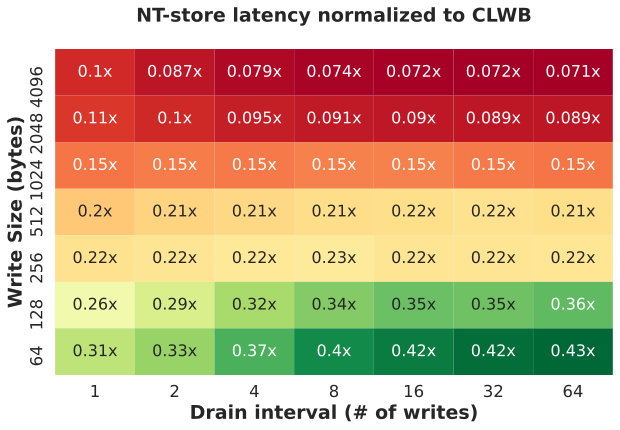

In [72]:
# sns.set()
g = sns.heatmap(
    df_pivot[2:][[1, 2, 4, 8, 16, 32, 64]], 
    annot=True, 
    annot_kws={"size": 16, 'label': 'colorbar title'}, 
    cmap=cmap, 
    cbar=False,
#     vmin=0, 
#     vmax=2, 
#     legend=False,
)

ax = g.axes
f = Fig(ax)
f.fmt_label('Drain interval (# of writes)', 'Write Size (bytes)',fontsize=fontsize+8)

for t in g.texts: t.set_text(t.get_text() + "x")

# ax.collections[0].colorbar.set_label("\n⟵ CLWB is faster           NT-Store is faster ⟶")
ax.set_title('NT-store latency normalized to CLWB\n', fontsize=fontsize+8, fontweight='bold')

    
f.save('clwbvsntstore')

In [12]:
import io
_df = pd.read_csv(io.StringIO("""pmdk,snashot,msync
1309827965,1225780573,
797215151,674379518,
752649700,623836241,
907402849,776246116,
88362592,69833385,
1441963984,1348662225,
1830593014,2228177769,"""), index_col=None)

In [11]:
_df_norm = _df['pmdk']/_df['snashot']

<AxesSubplot:>

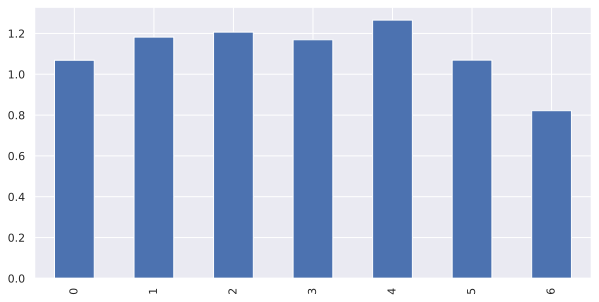

In [12]:
_df_norm.plot.bar()